# PUBG : Predict player placement

In this notebook, we are going to create an algorithm which will predict the placement (between 0 and 100) of a battle royal PUBG player.

The plan to do that is the following one :

1. Exploration of data
2. Features engineering
3. Cross validation testing of the model
4. Prediction on test data & submission on kaggle

![](https://static.gamespot.com/uploads/original/1197/11970954/3206264-pubg+artwork_.jpg)

## Imports

In [1]:
import pandas as pd
import matplotlib
import pydot
import re
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import seaborn as sns
import sklearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import gc
gc.enable()

# Functions

In [1]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Data

In [3]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train_V2.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test_V2.csv')

## 1. Data exploration

*Data fields:*

* **DBNOs** - Number of enemy players knocked.
* **assists** - Number of enemy players this player damaged that were killed by teammates.
* **boosts** - Number of boost items used.
* **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
* **headshotKills** - Number of enemy players killed with headshots.
* **heals** - Number of healing items used.
* **Id** - Player’s Id
* **killPlace** - Ranking in match of number of enemy players killed.
* **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* **killStreaks** - Max number of enemy players killed in a short amount of time.
* **kills** - Number of enemy players killed.
* **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* **matchDuration** - Duration of match in seconds.
* **matchId** - ID to identify match. There are no matches that are in both the training and testing set.
* **matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* **rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* **revives** - Number of times this player revived teammates.
* **rideDistance** - Total distance traveled in vehicles measured in meters.
* **roadKills** - Number of kills while in a vehicle.
* **swimDistance** - Total distance traveled by swimming measured in meters.
* **teamKills** - Number of times this player killed a teammate.
* **vehicleDestroys** - Number of vehicles destroyed.
* **walkDistance** - Total distance traveled on foot measured in meters.
* **weaponsAcquired** - Number of weapons picked up.
* **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* **groupId** - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* **numGroups** - Number of groups we have data for in the match.
* **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [4]:
#create dataframe for training dataset and print ten first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [7]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


*On a first look, we can suppose that there are no missing data ... let's verified it in the next cell !*

In [8]:
draw_missing_data_table(train_df_raw)

,Total,Percent
winPlacePerc,1,2.248724e-07
longestKill,0,0.000000e+00
groupId,0,0.000000e+00
matchId,0,0.000000e+00
assists,0,0.000000e+00
boosts,0,0.000000e+00
damageDealt,0,0.000000e+00
DBNOs,0,0.000000e+00
headshotKills,0,0.000000e+00
heals,0,0.000000e+00


*Only one missing data ! We will delete this row during features engineering*

In [9]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


*With those data we can see that one feature will need to be modified : the matchType feature. Indeed, any other features are already numerical and the Id related features are not taken into account for feature engineering.*

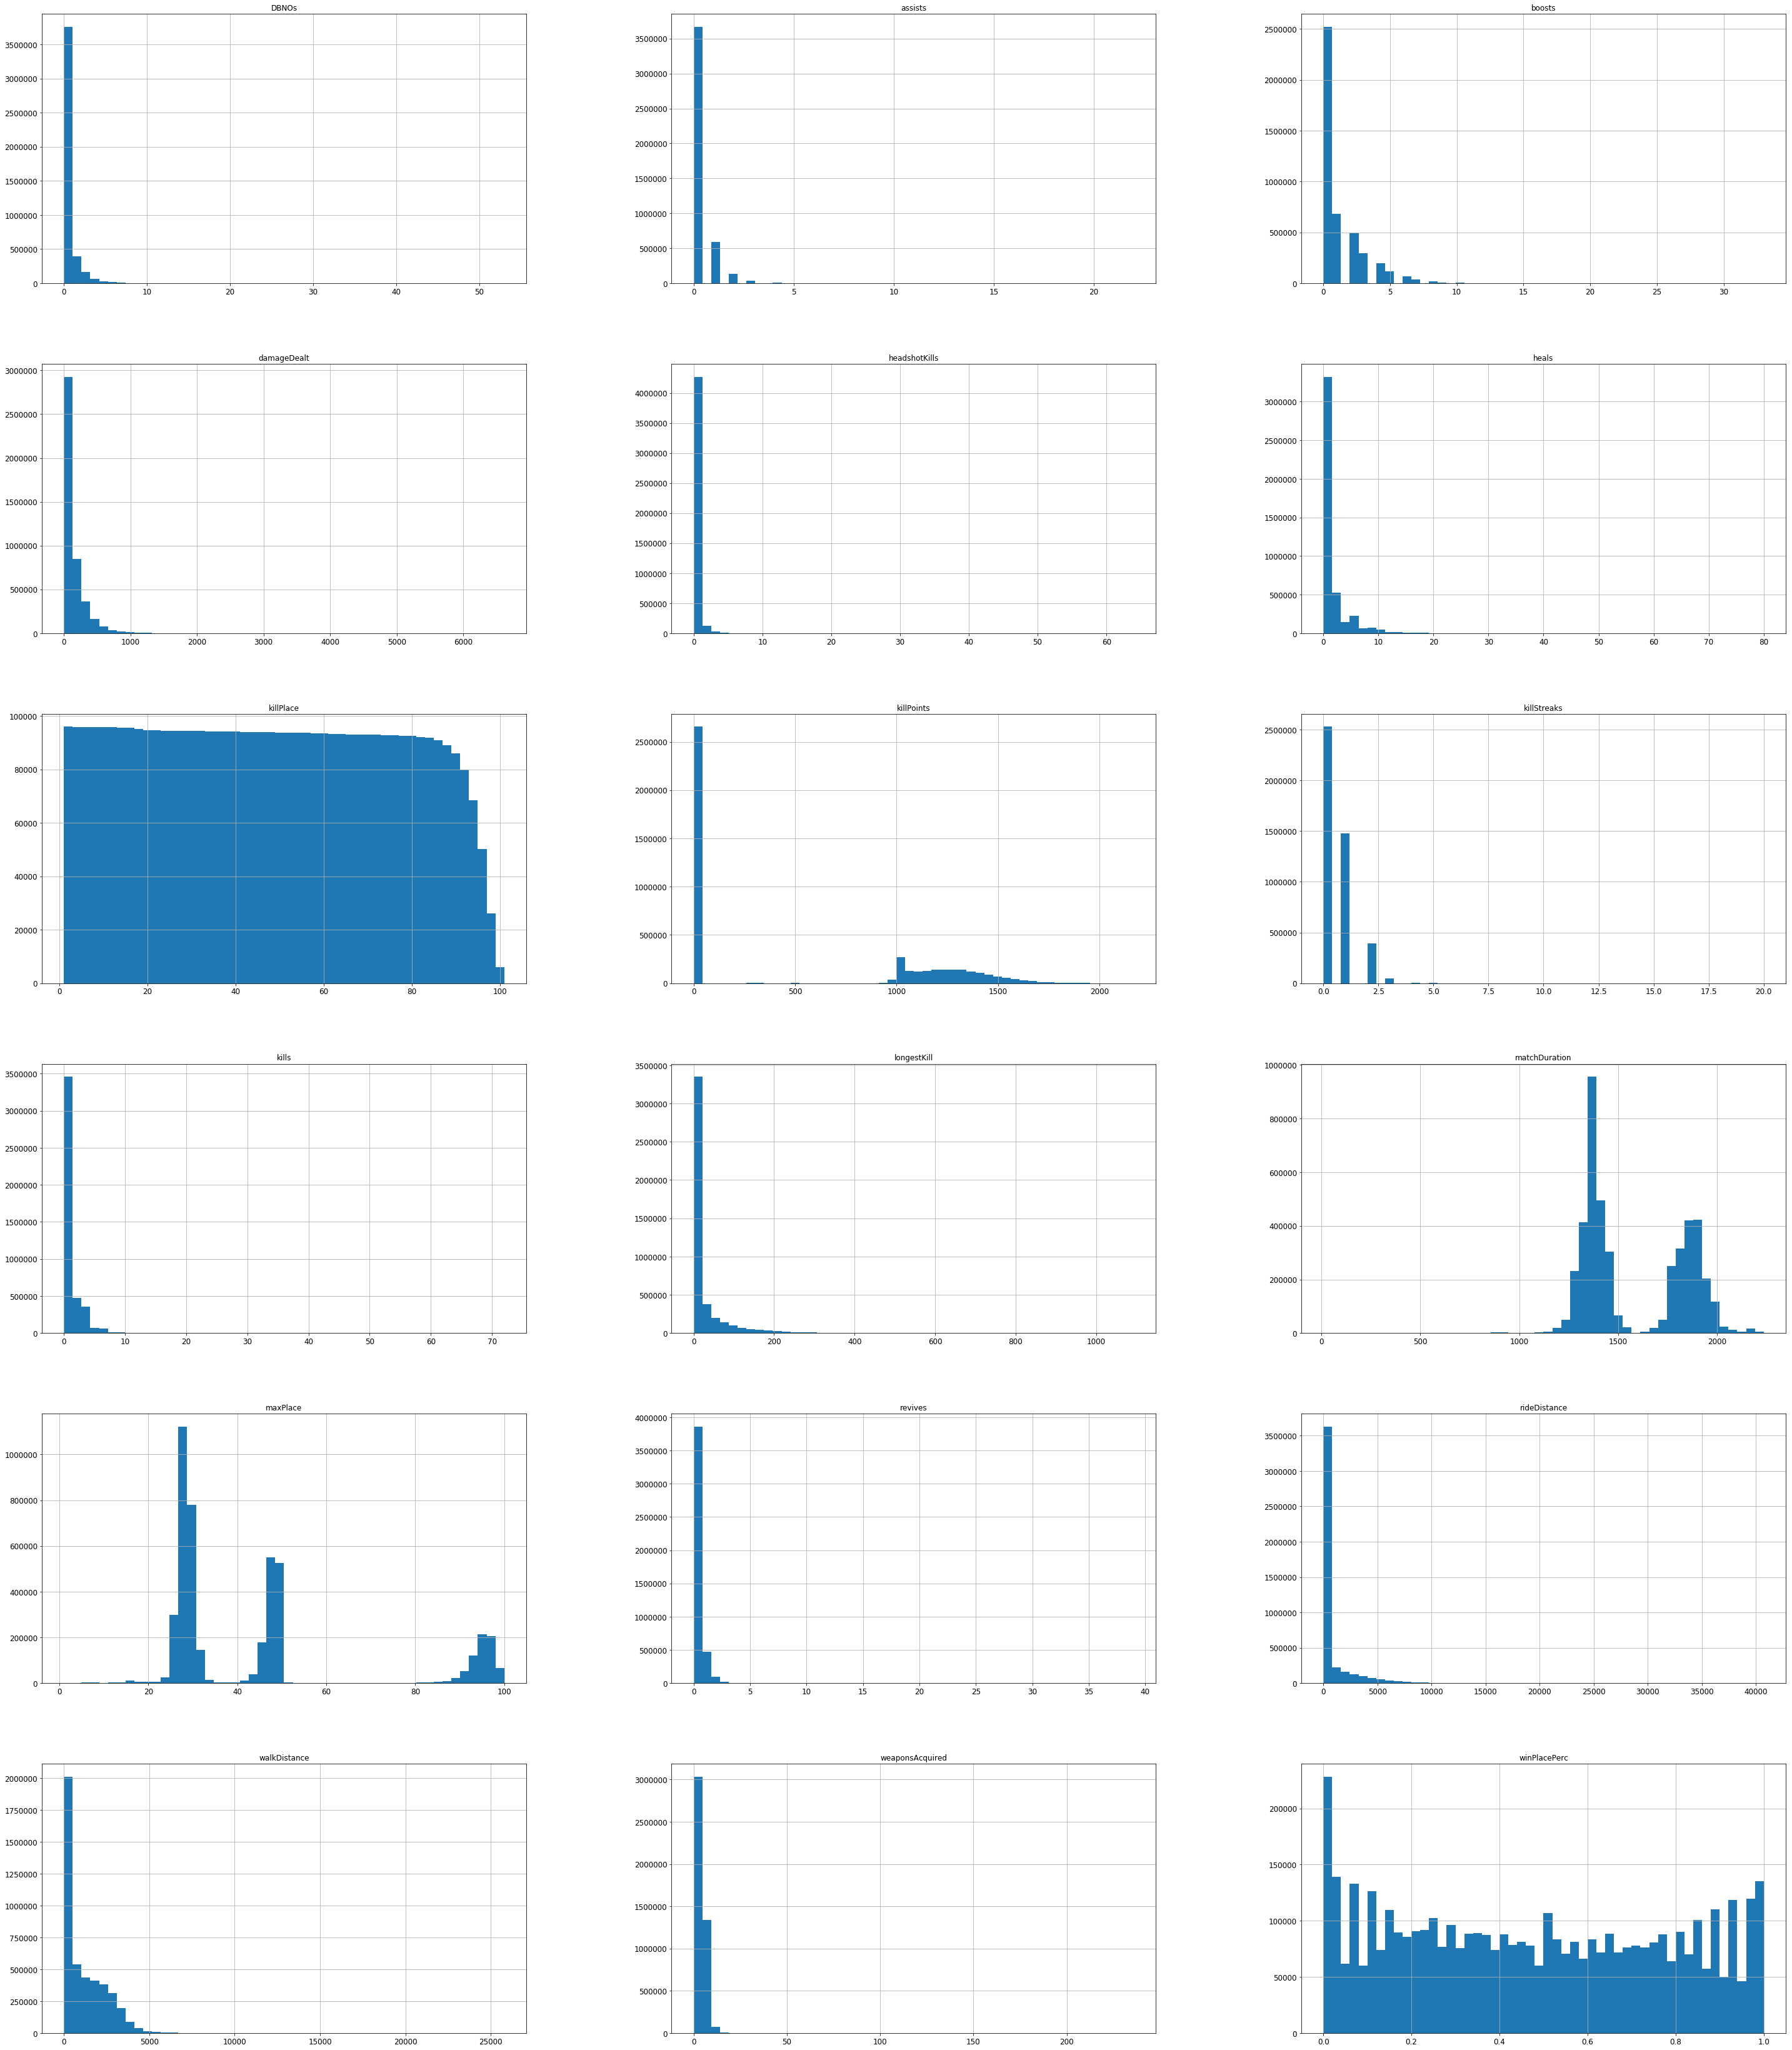

In [10]:
# Let's plot some histograms on main features to have a previzualisation of some of the data ...
train_df_raw.drop(['Id', 'groupId', 'matchId', 'winPoints', 'rankPoints', 'teamKills', 'vehicleDestroys', 'roadKills', 'swimDistance', 'numGroups'], 1).hist(bins=50, figsize=(50,80), layout=(8, 3))
plt.show()

### *With this first simple data exploration, we can observe that :*

* Majority of players have no kills at the end of the game (same conclusion for assists)
* Players who killed other players have between 1 and 10 kills (maximum in almost all cases, same conclusion for assists)
* Walk distance do not exeed 7000-8000 meters.
* We can identify low importance variables which are almost always zero: swim distance, vehicle destroyed, roadkills
* Teamkills are extremely rare but we can assume that when a player killed a teamate, it compromised a lot his placement so this variable can be relevant
* The killplace variable seem to show a strong correlation between placement and number of enemy players killed for the 0 to 90 placements and a decorrelation for the end of the placements (top 10 players).
* The final classement if well distributed between 0 and 100, with a majority of 0 probably consequence of early leaving of players.

## 2. Features engineering

### 2.1 Non numerical variables treatment

#### Let's take a look on the only non numerical variable of this dataset, the matchType column:

In [11]:
train_df_raw.matchType.unique().tolist()

['squad-fpp',
 'duo',
 'solo-fpp',
 'squad',
 'duo-fpp',
 'solo',
 'normal-squad-fpp',
 'crashfpp',
 'flaretpp',
 'normal-solo-fpp',
 'flarefpp',
 'normal-duo-fpp',
 'normal-duo',
 'normal-squad',
 'crashtpp',
 'normal-solo']

**Thoses data need to be explained, so after a few researchs it turns out that:**

- fpp means "first person player", those games are not very different than TPP games (third person player) so we won't treat those data differently.

- crash event is described by developpers as following: “In Crash Carnage, no firearms spawn so you’ll need to focus on melee weapons, throwables, and of course your driving skills to carry your duo to that final circle. Circles move considerably faster in this event, so loot quick, grab a vehicle, and crash your way to road warrior glory.” This mode is not standard so let's check whereas lots of data cmes from this game mode.

- flare event is a mode with a flare gun that allow to get some weapons and armor by calling a care package. This mode can be played with a 4 person team and it is not very different from basic squad mode so we will include flare games into squad games during feature engineering.

In [12]:
train_df_raw['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

Interresting ... Crash games are a minority : 0.1% of total games and about 0.5% of total duo games. With this observations, we can conclude that adding crash games to duo games will not skew the result of the prediction.

### 2.2 PCA

Let's create a formatted dataframe resulting of our learnings from here:

In [13]:
pca_df = train_df_raw.copy()
pca_df = pca_df.drop(['Id', 'groupId', 'matchId', 'rankPoints'],  axis=1)

# drop the only data line where winPlacePerc is null
null_data = pca_df[pca_df.isnull().any(axis=1)]
if not null_data.empty:
    pca_df = pca_df.drop([null_data.index[0]])

# handle matchType column
new_cols = list()
for t in pca_df['matchType']:
    if t in ['squad', 'squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp']:
        new_cols.append([1, 0, 0])
    elif t in ['solo', 'solo-fpp', 'normal-solo-fpp', 'normal-solo']:
        new_cols.append([0, 0, 1])
    else:
        new_cols.append([0, 1, 0])
match = pd.DataFrame(new_cols, columns=['squad','duo', 'solo'], index=pca_df.index)
pca_df = pca_df.join(match)
pca_df = pca_df.drop(['matchType'],  axis=1)

In [14]:
pca_df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,squad,duo,solo
0,0,0,0.00,0,0,0,60,1241,0,0,...,0.00,0,0,244.80,1,1466,0.4444,1,0,0
1,0,0,91.47,0,0,0,57,0,0,0,...,11.04,0,0,1434.00,5,0,0.6400,1,0,0
2,1,0,68.00,0,0,0,47,0,0,0,...,0.00,0,0,161.80,2,0,0.7755,0,1,0
3,0,0,32.90,0,0,0,75,0,0,0,...,0.00,0,0,202.70,3,0,0.1667,1,0,0
4,0,0,100.00,0,0,0,45,0,1,1,...,0.00,0,0,49.75,2,0,0.1875,0,0,1


We can see that we have, excluding the target, a total of 27 variable. This is a quite important number of variable and it can slow down our machine learning model a lot. It may be judicous to remove some of thoses variables which are strongly correlated to another variable to reduce the dimension of ou problem. Let's try to do that with a PCA.

In [15]:
X_pca = pca_df.drop('winPlacePerc', 1)  
y_pca = pca_df['winPlacePerc']

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=0)  

X_train_pca = standardize(X_train_pca)  
X_test_pca = standardize(X_test_pca)

In [16]:
pca = PCA()  
X_train = pca.fit_transform(X_train_pca)
X_test = pca.transform(X_test_pca)

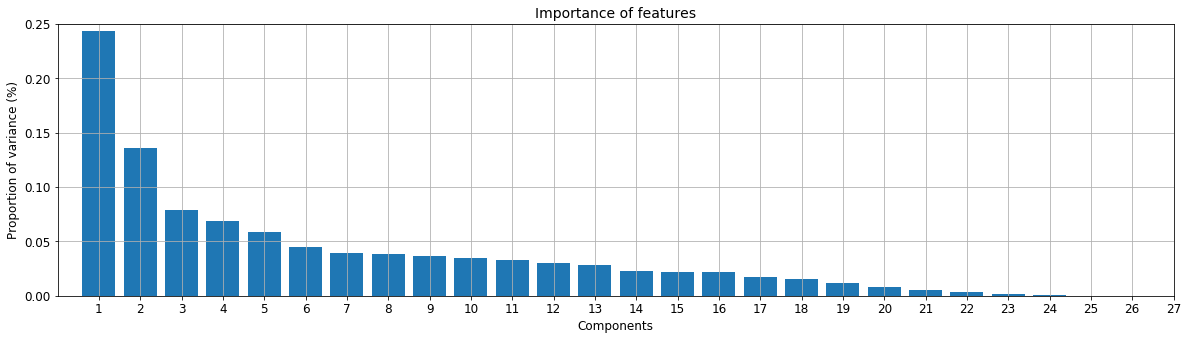

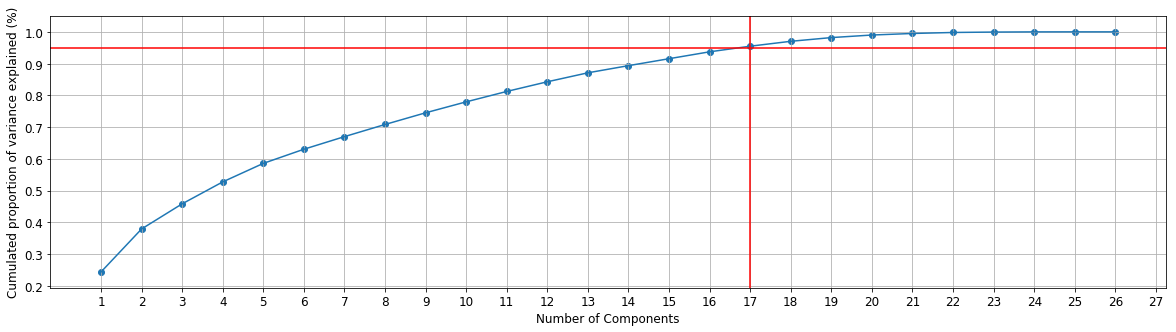

In [17]:
explained_variance = dict()
cumulated_variance = dict()
var_sum = 0
for n, var in enumerate(pca.explained_variance_ratio_):
    explained_variance.update({n+1: var})
    var_sum += var
    cumulated_variance.update({n+1: var_sum})
    
plt.close()
plt.figure(figsize=(20,5))
plt.bar(list(explained_variance.keys()), list(explained_variance.values()))
plt.title('Importance of features', fontsize=14)
plt.axis([0, 27, 0, 0.25])
plt.xticks(np.arange(1, 28, 1.0))
plt.grid(True)
plt.xlabel('Components', fontsize=12)
plt.ylabel('Proportion of variance (%)', fontsize=12)
plt.figure(figsize=(20,5))
plt.scatter(list(cumulated_variance.keys()), list(cumulated_variance.values()))
plt.plot(list(cumulated_variance.keys()), list(cumulated_variance.values()))
plt.plot(y=0.95, color='orange')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulated proportion of variance explained (%)', fontsize=12)
plt.xticks(np.arange(1, 28, 1.0))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=17, color='r', linestyle='-')
plt.grid(True)
plt.show()

With this PCA, we observe that the variables are not strongly correlated with each other. Indeed, the most important feature do not exeeds 25% of importance, and we we need a minimum of 17 variable to keep 95% of the variance ... We can conclude that it's not very not interresting to reduce our dataset.

We can confirm thoses observations with a correlation matrix:

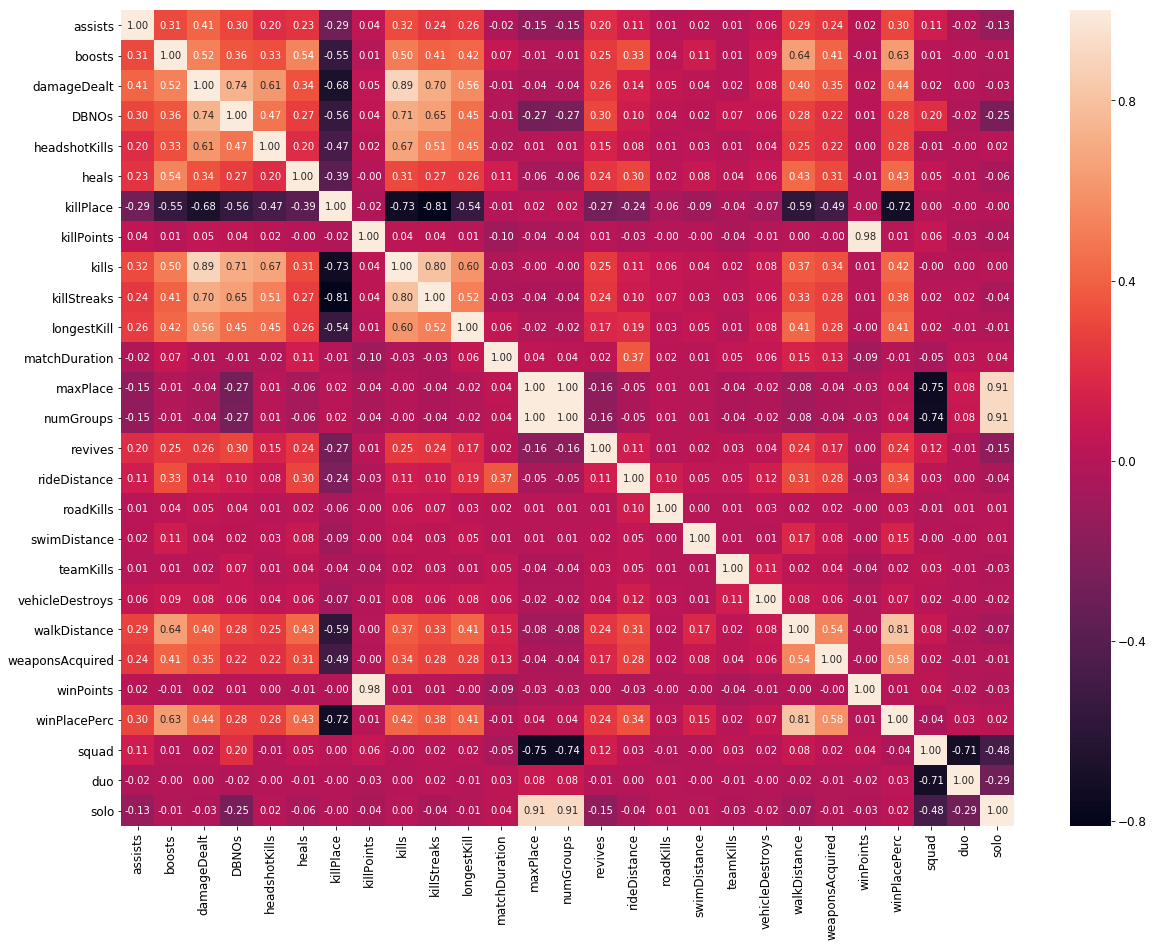

In [ ]:
plt.figure(figsize=(20,15))  
sns.heatmap(pca_df.corr(), annot=True, fmt=".2f")
plt.show()

- winPoints and killpoints seems to be redundant, indeed, players who are doing the biggest number of kills often win their games. We may delete one of those columns.
- obviously, damage dealt is strongly correlated withs number of kills, but not enought to delete one of those columns
- No other strong correlation can be spotted

In [ ]:
del pca_df
gc.collect()

37880

### 2.3 Formatting function

We now have enough informations do transform our data to make it ready for the machine learning algorithm. To do that, we will build a function that take a dataframe as argument and return a new fully formatted dataframe ready for prediction.

In [ ]:
def format_pubg_df(df, standardize=False, with_categorical=False):
    
    assert 'matchType' in df.columns.tolist(), 'please enter a valid dataframe !'
    assert 'Id' in df.columns.tolist(), 'please enter a valid dataframe !'
    assert 'groupId' in df.columns.tolist(), 'please enter a valid dataframe !'
    assert 'matchId' in df.columns.tolist(), 'please enter a valid dataframe !'

    processed_df = df.drop(['Id', 'groupId', 'rankPoints', 'killPoints'],  axis=1)
    
    # drop the only data line where winPlacePerc is null
    print('-'*5 + ' cleaning null data ' + '-'*5)
    null_data = processed_df[processed_df.isnull().any(axis=1)]
    if not null_data.empty:
        processed_df = processed_df.drop([null_data.index[0]])
            
    # handle matchType column by creating dummies cols or creating new categorical variable column
    print('-'*5 + ' handling matchType column ' + '-'*5)
    new_matchType_cols = list()
    if with_categorical:
        for mtype in processed_df['matchType']:
            if mtype in ['squad', 'squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp']:
                new_matchType_cols.append([3])
            elif mtype in ['solo', 'solo-fpp', 'normal-solo-fpp', 'normal-solo']:
                new_matchType_cols.append([1])
            else:
                new_matchType_cols.append([2])
        match_df = pd.DataFrame(new_matchType_cols, columns=['matchType'], index=processed_df.index)
        
    else:
        for mtype in processed_df['matchType']:
            if mtype in ['squad', 'squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp']:
                new_matchType_cols.append([1, 0, 0])
            elif mtype in ['solo', 'solo-fpp', 'normal-solo-fpp', 'normal-solo']:
                new_matchType_cols.append([0, 0, 1])
            else:
                new_matchType_cols.append([0, 1, 0])
        match_df = pd.DataFrame(new_matchType_cols, columns=['squad','duo', 'solo'], index=processed_df.index)
        
    processed_df = processed_df.drop(['matchType'],  axis=1)
    processed_df = processed_df.join(match_df)
    
    # create groupSize column
    processed_df['combinedId'] = processed_df['matchId'] + processed_df['groupId']
    group_size = processed_df.groupby(['combinedId']).size().reset_index(name='groupSize')
    processed_df = processed_df.merge(group_size, how='left', on=['combinedId'])
    processed_df = processed_df.drop(['combinedId'],  axis=1)
    
    # create matchSize column
    print('-'*5 + ' create matchSize column ' + '-'*5)
    match_size = processed_df.groupby(['matchId']).size().reset_index(name='matchSize')
    processed_df = processed_df.merge(match_size, how='left', on=['matchId'])
    processed_df = processed_df.drop(['matchId'],  axis=1)
    
    # create totalDistance col
    print('-'*5 + ' create totalDistance column ' + '-'*5)
    processed_df['totalDistance'] = processed_df['rideDistance'] + processed_df['walkDistance'] + processed_df['swimDistance']
    
    return processed_df

## 3. Make prediction

In [ ]:
train_df = format_pubg_df(train_df_raw, with_categorical=True)
X_train = train_df.drop('winPlacePerc', 1)
y_train = train_df['winPlacePerc']
X_train = standardize(X_train, categorical='matchType')
X_train.head()

----- cleaning null data -----
----- handling matchType column -----
----- create matchSize column -----
----- create totalDistance column -----


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,matchSize,totalDistance,matchType
0,-0.397257,-0.645129,-0.765410,-0.574191,-0.37668,-0.511252,0.451541,-0.593402,-0.765087,-0.451176,...,-0.047648,-0.147836,-0.142589,-0.085499,-0.768416,-1.083021,1.162011,0.269979,-0.696272,3
1,-0.397257,-0.645129,-0.229810,-0.574191,-0.37668,-0.511252,0.342303,-0.593402,-0.765087,-0.451176,...,-0.047648,0.214105,-0.142589,-0.085499,0.236403,0.545283,-0.819873,-0.477808,-0.146487,3
2,1.301767,-0.645129,-0.367238,-0.574191,-0.37668,-0.511252,-0.021824,-0.593402,-0.765087,-0.451176,...,-0.047648,-0.147836,-0.142589,-0.085499,-0.838547,-0.675945,-0.819873,0.569094,-0.734291,2
3,-0.397257,-0.645129,-0.572765,-0.574191,-0.37668,-0.511252,0.997732,-0.593402,-0.765087,-0.451176,...,-0.047648,-0.147836,-0.142589,-0.085499,-0.803989,-0.268869,-0.819873,-0.477808,-0.715556,3
4,-0.397257,-0.645129,-0.179863,-0.574191,-0.37668,-0.511252,-0.094650,0.048264,0.641438,0.697088,...,-0.047648,-0.147836,-0.142589,-0.085499,-0.933224,-0.675945,-0.819873,0.419537,-0.785617,1


In [ ]:
test_df_raw = pd.read_csv(path_test)
# assert there are no missing data as in the train dataframe
draw_missing_data_table(test_df_raw)

,Total,Percent
winPoints,0,0.0
weaponsAcquired,0,0.0
groupId,0,0.0
matchId,0,0.0
assists,0,0.0
boosts,0,0.0
damageDealt,0,0.0
DBNOs,0,0.0
headshotKills,0,0.0
heals,0,0.0


In [ ]:
# apply the same transformation on test dataset than on train dataset
X_test = format_pubg_df(test_df_raw, with_categorical=True)
X_test = standardize(X_test, categorical='matchType')
X_test.head()

----- cleaning null data -----
----- handling matchType column -----
----- create matchSize column -----
----- create totalDistance column -----


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,matchSize,totalDistance,matchType
0,-0.397435,-0.644382,-0.467522,-0.577010,-0.380549,-0.509436,0.917096,-0.602691,-0.766681,-0.451597,...,-0.046705,-0.148872,-0.14149,-0.083947,-0.475776,-1.113838,-0.825421,-0.531781,-0.535715,3
1,-0.397435,1.689575,0.294794,-0.577010,-0.380549,0.240838,-1.340508,0.709851,0.643734,6.704215,...,-0.046705,-0.148872,-0.14149,-0.083947,0.735581,1.005667,-0.825421,0.278561,2.288390,2
2,1.330900,-0.644382,-0.635108,-0.577010,-0.380549,0.991112,0.043185,-0.602691,-0.766681,-0.451597,...,-0.046705,-0.148872,-0.14149,-0.083947,-0.306407,0.157865,-0.825421,-0.126610,-0.443184,3
3,-0.397435,-0.644382,-0.383551,-0.577010,-0.380549,-0.509436,0.225250,-0.602691,-0.766681,-0.451597,...,-0.046705,-0.148872,-0.14149,-0.083947,0.561804,-0.266036,-0.825421,-1.139538,0.031144,2
4,-0.397435,1.689575,1.197223,0.305066,2.989906,-0.134299,-1.486160,1.366122,0.643734,0.735964,...,-0.046705,-0.148872,-0.14149,-0.083947,1.537502,0.157865,-0.825421,0.075976,0.564195,3


In [ ]:
# Create and train model on train data sample
params = {
    'num_leaves': 500,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'num_iterations': 400,
    #'max_depth':10,
    #'min_data_in_leaf': 100,
    'max_bin': 1000,
    #'bagging_fraction':0.8,
    #'bagging_freq':5,
    #'feature_fraction':0.9,
    #'verbose':50,
    #'boosting_type': 'rf',
    'random_state': 42,
    'objective' : 'regression',
    'categorical_feature': 25
    }

model = lgb.LGBMRegressor(**params, verbose=2, silent=False)
model.fit(X_train, y_train, eval_metric= 'mae')

In [ ]:
# Predict for test data sample
prediction = model.predict(X_test)

In [ ]:
# Tip found here: https://www.kaggle.com/anycode/simple-nn-baseline-3
for i in range(len(test_df_raw)):
    winPlacePerc = prediction[i]
    maxPlace = int(test_df_raw.iloc[i]['maxPlace'])
    if maxPlace == 0:
        winPlacePerc = 0.0
    elif maxPlace == 1:
        winPlacePerc = 1.0
    else:
        gap = 1.0 / (maxPlace - 1)
        winPlacePerc = round(winPlacePerc / gap) * gap
    
    if winPlacePerc < 0: winPlacePerc = 0.0
    if winPlacePerc > 1: winPlacePerc = 1.0    
    prediction[i] = winPlacePerc

In [ ]:
result_df = test_df_raw.copy()
result_df['winPlacePerc'] = prediction

result_df.head()
result_df.to_csv('submission.csv', columns=['Id', 'winPlacePerc'], index=False)